# Multi-Sensor Lake Ice Phenology Detection
## Alaska Thermokarst Lakes - Sentinel-1 + Sentinel-2 + ERA5 Approach

**Goal:** Detect ice-on and ice-off dates for ~550 Alaska lakes using multi-sensor fusion

**Approach:**
1. Use Sentinel-2 NDSI as high-confidence ground truth (after clouds filter, and excluding summer algal blooms based on ERA5 temperature)
2. Train Random Forest on S1 features using S2 labels
3. Use the trained model to interpolate between S2 observations
4. Use all three datasets to detect ice-on/ice-off dates
   
**Loosely based on (more like inspired by):** [Tom et al. (2020)](https://isprs-annals.copernicus.org/articles/V-3-2020/409/2020/isprs-annals-V-3-2020-409-2020.pdf) - using optical data to train SAR interpretation

---
## Part 1: Setup and Configuration

In [3]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Initialize Earth Engine
ee.Initialize()

print("Imports successful!")
print(f"Earth Engine initialized: {ee.String('GEE Initialized').getInfo()}")

httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.
httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.
httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.
httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.


Imports successful!
Earth Engine initialized: GEE Initialized


In [4]:
# Configuration
YEAR = 2023
BUCKET = 'wustl-eeps-geospatial'
LAKE_ASSET = 'projects/eeps-geospatial/assets/alaska_lakes' 
LAKE_ID_FIELD = 'id'
SCALE = 10  # Sentinel-1 resolution

# Use Alaska Albers equal area projection for lake areas
proj_ak = ee.Projection('EPSG:3338')

print(f"Configuration set for year {YEAR}")
print(f"Will export to gs://{BUCKET}/thermokarst_lakes/")

Configuration set for year 2023
Will export to gs://wustl-eeps-geospatial/thermokarst_lakes/


---
## Part 2: Load and Prepare Lake Geometries

In [5]:
# Load lakes from GEE Asset collection (Claire's shapefile)
lakes = ee.FeatureCollection(LAKE_ASSET)
print(f"Loaded {lakes.size().getInfo()} lakes")

# Add lake geometries
def add_geom_metrics(feat):
    geom = feat.geometry().transform(proj_ak, 1)
    area = geom.area(1)
    perim = geom.perimeter(1)
    centroid = geom.centroid(1)
    coords = centroid.coordinates()
    
    # Existing metrics
    circularity = ee.Number(4).multiply(ee.Number(np.pi)).multiply(area).divide(perim.pow(2))
    
    # Fractal dimension ish (perimeter-area relationship)
    # D = 2 * ln(perimeter/4) / ln(area)
    fractal_dim = ee.Number(2).multiply(
        perim.divide(4).log().divide(area.log())
    )
    
    # Convexity
    convex_hull = geom.convexHull(1)
    convex_area = convex_hull.area(1)
    convexity = area.divide(convex_area)
    
    return feat.set({
        'lake_area_m2': area,
        'lake_perim_m': perim,
        'circularity': circularity,
        'fractal_dim': fractal_dim,
        'convexity': convexity,
        'centroid_lon': coords.get(0),
        'centroid_lat': coords.get(1)
    })

lakes_with_geom = lakes.map(add_geom_metrics)

# Create buffered lake interiors to get rid of that weird area with thin ice
def buffer_interior(feat):
    geom = feat.geometry()
    area = geom.area()
    
    # Use fixed 10m negative buffer
    # previously tried keeping interior 67% approach but
    # it was too aggressive on small lakes
    buffered = geom.buffer(-10)
    # For very small lakes, just use original geometry
    buffered = ee.Algorithms.If(
        area.lt(10000),  # If lake < 10,000 m^2
        geom,            # Use full lake
        buffered         # Otherwise use 10m buffer
    )   
    return feat.setGeometry(ee.Geometry(buffered))

lakes_buf = lakes_with_geom.map(buffer_interior)

# Create landscape rings (100m around lakes. This might be too big?)
def create_landscape_ring(feat):
    lake_geom = feat.geometry()
    outer_buffer = lake_geom.buffer(100)
    ring = outer_buffer.difference(lake_geom)
    return feat.setGeometry(ring)

landscape_rings = lakes_with_geom.map(create_landscape_ring)

print("Lake geometries prepared:")
print("  - Original lakes")
print("  - Buffered interiors (10m)")
print("  - Landscape rings (100m)")

Loaded 541 lakes
Lake geometries prepared:
  - Original lakes
  - Buffered interiors (10m)
  - Landscape rings (100m)


---
## Part 3: Define Data Collection Functions

In [10]:
# Sentinel-1 collection
def get_s1_collection(year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = start.advance(1, 'year')
    
    coll = (ee.ImageCollection('COPERNICUS/S1_GRD')
            .filterBounds(lakes.geometry())
            .filterDate(start, end)
            .filter(ee.Filter.eq('instrumentMode', 'IW'))
            .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
            .filter(ee.Filter.eq('resolution_meters', 10)))
    
    def prep_s1(img):
        angle = img.select('angle')
        angle_mask = angle.gt(25).And(angle.lt(50))
        
        # Process VV
        vv_lin = ee.Image(10.0).pow(img.select('VV').divide(10.0)).updateMask(angle_mask)
        vv_lin_f = vv_lin.focal_mean(1)
        vv_db = vv_lin_f.log10().multiply(10).rename('VV_db')
        
        # Process VH
        vh_lin = ee.Image(10.0).pow(img.select('VH').divide(10.0)).updateMask(angle_mask)
        vh_lin_f = vh_lin.focal_mean(1)
        vh_db = vh_lin_f.log10().multiply(10).rename('VH_db')
        
        return vv_db.addBands(vh_db).copyProperties(img, img.propertyNames())
    
    return coll.map(prep_s1)

# Sentinel-2 collection with s2cloudless pixel-level cloud masking
def get_s2_collection(year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = start.advance(1, 'year')
    
    # Get S2 SR collection
    s2_sr = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
            .filterBounds(lakes.geometry())
            .filterDate(start, end)
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 80))) #move up to 80 and use s2cloudless
    
    # Get s2cloudless collection. using this instead of QA60
    s2_cloudless = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
                    .filterBounds(lakes.geometry())
                    .filterDate(start, end))
    
    # Join the two collections
    def join_collections(s2_img):
        # Find matching s2cloudless image (within 1 hour)
        time_diff = ee.Filter.maxDifference(
            difference=1 * 60 * 60 * 1000,  # 1 hour in milliseconds
            leftField='system:time_start',
            rightField='system:time_start'
        )
        join = ee.Join.saveFirst('cloud_mask')
        joined = ee.ImageCollection(join.apply(
            ee.ImageCollection([s2_img]),
            s2_cloudless,
            time_diff
        ))
        return ee.Image(joined.first())
    
    def compute_ndsi(img):
        # Get cloud probability
        cloud_prob = ee.Image(img.get('cloud_mask')).select('probability')
        
        # Cloud mask: probability < 20%
        is_not_cloud = cloud_prob.lt(20)
        
        # NDSI = (Green - SWIR1) / (Green + SWIR1)
        ndsi = img.normalizedDifference(['B3', 'B11']).rename('ndsi').updateMask(is_not_cloud)
        
        # Ice mask: NDSI > 0.45 (tightened this from 0.4)
        ice_mask = ndsi.gt(0.45).rename('ice')
        
        return img.addBands(ndsi).addBands(ice_mask).addBands(cloud_prob.rename('cloud_prob'))
    
    # Apply join and compute NDSI
    joined = s2_sr.map(join_collections)
    return joined.map(compute_ndsi)

s2 = get_s2_collection(YEAR)
print(f"S2 images with s2cloudless: {s2.size().getInfo()}")

# ERA5 temperature collection
def get_era5_collection(year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = start.advance(1, 'year')
    
    # Get daily mean temperature
    era5 = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY').filterDate(start, end).select('temperature_2m')
    
    # Convert to daily means
    days = ee.List.sequence(0, 364)  # 365 days
    
    def daily_mean(day):
        date = start.advance(day, 'day')
        daily = era5.filterDate(date, date.advance(1, 'day')).mean()
        # Convert Kelvin to Celsius
        temp_c = daily.subtract(273.15).rename('temp_c')
        return temp_c.set('system:time_start', date.millis())
    
    return ee.ImageCollection.fromImages(days.map(daily_mean))

print("Data collection functions defined")

S2 images with s2cloudless: 737
Data collection functions defined


---
## Part 4: Export Multi-Sensor Data

This will export three separate CSVs:
1. Sentinel-1 time series (VV, VH, RGB features)
2. Sentinel-2 time series (NDSI, ice fraction)
3. ERA5 daily temperature

We'll merge them later in Python.

In [13]:
# Load collections
s1 = get_s1_collection(YEAR)
s2 = get_s2_collection(YEAR)
era5 = get_era5_collection(YEAR)

print(f"S1 images: {s1.size().getInfo()}")
print(f"S2 images: {s2.size().getInfo()}")
print(f"ERA5 daily images: {era5.size().getInfo()}")

S1 images: 28
S2 images: 737
ERA5 daily images: 365


### Export 1: Sentinel-1 Data

In [14]:
def s1_to_features(img):
    vv_img = img.select('VV_db')
    vh_img = img.select('VH_db')
    
    # RGB bands
    r_band = vv_img.unitScale(-20, -5).multiply(255).byte().rename('R')
    g_band = vh_img.unitScale(-28, -12).multiply(255).byte().rename('G')
    b_band = vv_img.subtract(vh_img).unitScale(8, 18).multiply(255).byte().rename('B')
    
    rgb_img = ee.Image.cat([r_band, g_band, b_band])
    date_str = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd')
    
    # Reducers
    vv_reducer = ee.Reducer.mean().combine(ee.Reducer.count(), sharedInputs=True)
    vh_reducer = ee.Reducer.mean()
    rgb_reducer = ee.Reducer.mean()
    
    # Reduce over lake interiors
    vv_stats = vv_img.reduceRegions(
        collection=lakes_buf,
        reducer=vv_reducer,
        scale=SCALE,
        tileScale=2
    )
    
    vh_stats = vh_img.reduceRegions(
        collection=lakes_buf,
        reducer=vh_reducer,
        scale=SCALE,
        tileScale=2
    )
    
    rgb_stats = rgb_img.reduceRegions(
        collection=lakes_buf,
        reducer=rgb_reducer,
        scale=SCALE,
        tileScale=2
    )
    
    # Landscape context
    land_stats = rgb_img.reduceRegions(
        collection=landscape_rings,
        reducer=rgb_reducer,
        scale=SCALE,
        tileScale=2
    )
    
    def add_metadata(f):
        lake_id_prop = f.get(LAKE_ID_FIELD)
        
        # Get stats for this lake
        vh_feature = vh_stats.filter(ee.Filter.eq(LAKE_ID_FIELD, lake_id_prop)).first()
        rgb_feature = rgb_stats.filter(ee.Filter.eq(LAKE_ID_FIELD, lake_id_prop)).first()
        land_feature = land_stats.filter(ee.Filter.eq(LAKE_ID_FIELD, lake_id_prop)).first()
        
        # Get geometry metrics from original
        orig = lakes_with_geom.filter(ee.Filter.eq(LAKE_ID_FIELD, lake_id_prop)).first()
        
        # FIXED: Handle null VH values safely
        vv_val = ee.Number(f.get('mean'))
        vh_val = ee.Number(vh_feature.get('mean'))
        
        # Only compute ratio if both values exist
        vv_vh_ratio = ee.Algorithms.If(
            vh_feature.get('mean'),  # Check if VH exists
            vv_val.subtract(vh_val),  # Compute if exists
            ee.Number(-999)  # Null flag if missing
        )
        
        return (f.set('date', date_str)
                .set('sensor', 'S1')
                .set('vv_db', vv_val)
                .set('vh_db', vh_val)
                .set('vv_vh_ratio', vv_vh_ratio)
                .set('lake_R', rgb_feature.get('R'))
                .set('lake_G', rgb_feature.get('G'))
                .set('lake_B', rgb_feature.get('B'))
                .set('land_R', land_feature.get('R'))
                .set('land_G', land_feature.get('G'))
                .set('land_B', land_feature.get('B'))
                .set('lake_area_m2', orig.get('lake_area_m2'))
                .set('centroid_lon', orig.get('centroid_lon'))
                .set('centroid_lat', orig.get('centroid_lat'))
                .set('lake_id', ee.Number(lake_id_prop).toInt()))
    
    return vv_stats.map(add_metadata)

# Map over S1 images
s1_features = s1.map(s1_to_features).flatten()

# Export
s1_cols = [
    'lake_id', 'date', 'sensor',
    'vv_db', 'vh_db', 'vv_vh_ratio',
    'lake_R', 'lake_G', 'lake_B',
    'land_R', 'land_G', 'land_B',
    'lake_area_m2', 'centroid_lon', 'centroid_lat'
]

task_s1 = ee.batch.Export.table.toCloudStorage(
    collection=s1_features.select(s1_cols),
    description=f'Alaska_Lakes_S1_{YEAR}',
    bucket=BUCKET,
    fileNamePrefix=f'thermokarst_lakes/Alaska_Lakes_S1_{YEAR}',
    fileFormat='CSV',
    selectors=s1_cols
)

task_s1.start()
print(f"Started S1 export: {task_s1.id}")

Started S1 export: Y72APNNCLFVCGQ7WB5HPDVRI


### Export 2: Sentinel-2 Data

In [15]:
def s2_to_features(img):
    """
    Only export S2 data for lakes that this image actually covers
    """
    ice_img = img.select('ice')
    ndsi_img = img.select('ndsi')
    date_str = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd')
    
    # Only process lakes that intersect this image's footprint
    img_bounds = img.geometry()
    lakes_in_image = lakes_buf.filterBounds(img_bounds)
    
    # Reduce over lake interiors (only those in this image)
    ice_stats = ice_img.reduceRegions(
        collection=lakes_in_image,  # Only lakes covered by this image
        reducer=ee.Reducer.mean(),
        scale=20,  # S2 SWIR resolution
        tileScale=2
    )
    
    ndsi_stats = ndsi_img.reduceRegions(
        collection=lakes_in_image,  # Only lakes covered by this image
        reducer=ee.Reducer.mean(),
        scale=20,
        tileScale=2
    )
    
    def add_metadata(f):
        lake_id_prop = f.get(LAKE_ID_FIELD)
        ndsi_feature = ndsi_stats.filter(ee.Filter.eq(LAKE_ID_FIELD, lake_id_prop)).first()
        orig = lakes_with_geom.filter(ee.Filter.eq(LAKE_ID_FIELD, lake_id_prop)).first()
        
        return (f.set('date', date_str)
                .set('sensor', 'S2')
                .set('ice_fraction', f.get('mean'))  # Fraction of pixels with ice
                .set('ndsi_mean', ndsi_feature.get('mean'))
                .set('lake_area_m2', orig.get('lake_area_m2'))
                .set('centroid_lon', orig.get('centroid_lon'))
                .set('centroid_lat', orig.get('centroid_lat'))
                .set('lake_id', ee.Number(lake_id_prop).toInt()))
    
    return ice_stats.map(add_metadata)

# Map over S2 images
s2_features = s2.map(s2_to_features).flatten()

# Export
s2_cols = [
    'lake_id', 'date', 'sensor',
    'ice_fraction', 'ndsi_mean',
    'lake_area_m2', 'centroid_lon', 'centroid_lat'
]

task_s2 = ee.batch.Export.table.toCloudStorage(
    collection=s2_features.select(s2_cols),
    description=f'Alaska_Lakes_S2_{YEAR}',
    bucket=BUCKET,
    fileNamePrefix=f'thermokarst_lakes/Alaska_Lakes_S2_{YEAR}',
    fileFormat='CSV',
    selectors=s2_cols
)

task_s2.start()
print(f"Started S2 export: {task_s2.id}")

Started S2 export: 5VYWGW7NLNUHRMPAPJQWRIUX


### Export 3: ERA5 Temperature Data

In [16]:
# Get ERA5 as daily image collection
def get_era5_daily_grid(year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = start.advance(1, 'year')
    
    era5 = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY').filterDate(start, end).select('temperature_2m')
    
    # Create daily means
    days = ee.List.sequence(0, 364)
    
    def daily_mean(day):
        date = start.advance(day, 'day')
        daily = era5.filterDate(date, date.advance(1, 'day')).mean()
        temp_c = daily.subtract(273.15).rename('temp_c')
        return temp_c.set('system:time_start', date.millis()).set('date', date.format('YYYY-MM-dd'))
    
    return ee.ImageCollection.fromImages(days.map(daily_mean))

era5_daily = get_era5_daily_grid(YEAR)

# Create point features at lake centroids
lake_points = lakes_with_geom.map(
    lambda f: ee.Feature(
        f.geometry().centroid(),
        {
            'lake_id': f.get(LAKE_ID_FIELD),
            'centroid_lon': f.get('centroid_lon'),
            'centroid_lat': f.get('centroid_lat')
        }
    )
)

print(f"Created {lake_points.size().getInfo()} lake centroid points")

# Sample temperature at each lake centroid for each day
def sample_at_lakes(img):
    date_str = img.get('date')
    
    # Sample at points - one point per lake should be fine
    samples = img.select('temp_c').sampleRegions(
        collection=lake_points,
        scale=11000,
        geometries=False
    )
    
    # Add date to each sample
    def add_date(f):
        return f.set('date', date_str).set('sensor', 'ERA5')
    
    return samples.map(add_date)

print("Sampling ERA5 at lake centroids...")
era5_features = era5_daily.map(sample_at_lakes).flatten()

# Export
era5_cols = ['lake_id', 'date', 'sensor', 'temp_c', 'centroid_lon', 'centroid_lat']

task_era5 = ee.batch.Export.table.toCloudStorage(
    collection=era5_features.select(era5_cols),
    description=f'Alaska_Lakes_ERA5_{YEAR}',
    bucket=BUCKET,
    fileNamePrefix=f'thermokarst_lakes/Alaska_Lakes_ERA5_{YEAR}',
    fileFormat='CSV',
    selectors=era5_cols
)

task_era5.start()
print(f"Started ERA5 export: {task_era5.id}")

Created 541 lake centroid points
Sampling ERA5 at lake centroids...
Started ERA5 export: EM77AVLMHMA7VZUFUXCJBF76


In [19]:
print("\n" + "="*60)
print("ALL EXPORTS STARTED")
print("="*60)
print(f"S1 task:   {task_s1.id}")
print(f"S2 task:   {task_s2.id}")
print(f"ERA5 task: {task_era5.id}")
print("\nTrack status in taksks panel at GEE console")
print("\nCSVs export to GCS bucket")


ALL EXPORTS STARTED
S1 task:   Y72APNNCLFVCGQ7WB5HPDVRI
S2 task:   5VYWGW7NLNUHRMPAPJQWRIUX
ERA5 task: EM77AVLMHMA7VZUFUXCJBF76

Track status in taksks panel at GEE console

CSVs export to GCS bucket


---
## Part 5: Load and Merge Multi-Sensor Data

**Wait for complete exports**

In [24]:
# Load the CSVs
df_s1 = pd.read_csv(f'gs://{BUCKET}/thermokarst_lakes/Alaska_Lakes_S1_2023.csv')
df_s2 = pd.read_csv(f'gs://{BUCKET}/thermokarst_lakes/Alaska_Lakes_S2_2023.csv')
df_era5 = pd.read_csv(f'gs://{BUCKET}/thermokarst_lakes/Alaska_Lakes_ERA5_2023.csv')

# Convert dates
df_s1['date'] = pd.to_datetime(df_s1['date'])
df_s2['date'] = pd.to_datetime(df_s2['date'])
df_era5['date'] = pd.to_datetime(df_era5['date'])

print("Data loaded:")
print(f"  S1:   {len(df_s1):,} observations across {df_s1['lake_id'].nunique()} lakes")
print(f"  S2:   {len(df_s2):,} observations across {df_s2['lake_id'].nunique()} lakes")
print(f"  ERA5: {len(df_era5):,} observations across {df_era5['lake_id'].nunique()} lakes")

# Merge S1 + temperature (every S1 obs gets a temp)
df_s1 = df_s1.merge(df_era5[['lake_id', 'date', 'temp_c']], on=['lake_id', 'date'], how='left')

print(f"\nMerged S1 + temperature: {len(df_s1):,} observations")
print(f"Temperature coverage: {df_s1['temp_c'].notna().sum() / len(df_s1) * 100:.1f}%")

Data loaded:
  S1:   15,148 observations across 541 lakes
  S2:   100,311 observations across 541 lakes
  ERA5: 191,625 observations across 525 lakes

Merged S1 + temperature: 15,148 observations
Temperature coverage: 97.0%


In [25]:
# Deduplicate: keep only one S2 observation per lake per date
before_count = len(df_s2)
print(f"Before deduplication: {before_count:,} rows")

# For duplicates, keep the one with least ambiguous ice_fraction (furthest from 0.5)
df_s2['confidence'] = (df_s2['ice_fraction'] - 0.5).abs()
df_s2 = df_s2.sort_values('confidence', ascending=False).drop_duplicates(
    subset=['lake_id', 'date'], 
    keep='first'
)
df_s2 = df_s2.drop(columns='confidence')

after_count = len(df_s2)
print(f"After deduplication:  {after_count:,} rows")
print(f"Removed {before_count - after_count:,} duplicate observations ({(before_count - after_count) / before_count * 100:.1f}%)")

Before deduplication: 100,311 rows
After deduplication:  55,247 rows
Removed 45,064 duplicate observations (44.9%)


In [26]:
# S2 coverage statistics
print("\nSentinel-2 Coverage Analysis:")
print("="*60)

s2_per_lake = df_s2.groupby('lake_id').size()
print(f"S2 observations per lake:")
print(f"  Mean:   {s2_per_lake.mean():.1f}")
print(f"  Median: {s2_per_lake.median():.0f}")
print(f"  Min:    {s2_per_lake.min():.0f}")
print(f"  Max:    {s2_per_lake.max():.0f}")

# Merge temperature onto S2 data for label cleaning
print("\nMerging temperature data onto S2 observations...")
df_s2 = df_s2.merge(df_era5[['lake_id', 'date', 'temp_c']], 
                    on=['lake_id', 'date'], how='left')
print(f"Temperature coverage in S2 data: {df_s2['temp_c'].notna().sum() / len(df_s2) * 100:.1f}%")

# Add month for diagnostics
df_s2['month'] = df_s2['date'].dt.month

# Compute 7-day rolling mean temperature for each lake
print("\nComputing 7-day temperature trends...")
df_s2 = df_s2.sort_values(['lake_id', 'date'])
df_s2['temp_7day_mean'] = df_s2.groupby('lake_id')['temp_c'].transform(
    lambda x: x.rolling(window=7, min_periods=3, center=False).mean()
)

# Create initial ice state labels from S2
df_s2['s2_ice_state'] = 'PARTIAL'
df_s2.loc[df_s2['ice_fraction'] > 0.6, 's2_ice_state'] = 'ICE'    
df_s2.loc[df_s2['ice_fraction'] < 0.4, 's2_ice_state'] = 'WATER'

print(f"\nInitial S2 ice classification (before temperature filtering):")
print(df_s2['s2_ice_state'].value_counts())

# Apply temperature trend constraints (not single-day)
ice_labels = df_s2['s2_ice_state'] == 'ICE'
water_labels = df_s2['s2_ice_state'] == 'WATER'
temp_7day_available = df_s2['temp_7day_mean'].notna()

# Sustained warm period -> ice impossible
# 7-day mean > 10°C means consistent warmth, ice should have melted
impossible_ice_warm_trend = (ice_labels & temp_7day_available & 
                             (df_s2['temp_7day_mean'] > 5))

# Sustained cold period -> water impossible  
# 7-day mean < -5°C means consistent cold, water should have frozen
impossible_water_cold_trend = (water_labels & temp_7day_available & 
                               (df_s2['temp_7day_mean'] < -5))

df_s2.loc[impossible_ice_warm_trend, 's2_ice_state'] = 'WATER'
df_s2.loc[impossible_water_cold_trend, 's2_ice_state'] = 'ICE'

print(f"\nCleaned S2 ice classification (after 7-day temperature trend filtering):")
print(df_s2['s2_ice_state'].value_counts())
print(f"  Overridden as WATER (7-day mean temp > 10°C): {impossible_ice_warm_trend.sum()}")
print(f"  Overridden as ICE (7-day mean temp < -5°C): {impossible_water_cold_trend.sum()}")
print(f"\nClear detections (ICE or WATER): {((df_s2['s2_ice_state'] == 'ICE') | (df_s2['s2_ice_state'] == 'WATER')).sum() / len(df_s2) * 100:.1f}%")


Sentinel-2 Coverage Analysis:
S2 observations per lake:
  Mean:   102.1
  Median: 101
  Min:    78
  Max:    140

Merging temperature data onto S2 observations...
Temperature coverage in S2 data: 97.0%

Computing 7-day temperature trends...

Initial S2 ice classification (before temperature filtering):
s2_ice_state
PARTIAL    43873
ICE         8003
WATER       3371
Name: count, dtype: int64

Cleaned S2 ice classification (after 7-day temperature trend filtering):
s2_ice_state
PARTIAL    43873
ICE         7441
WATER       3933
Name: count, dtype: int64
  Overridden as WATER (7-day mean temp > 10°C): 562
  Overridden as ICE (7-day mean temp < -5°C): 0

Clear detections (ICE or WATER): 20.6%


In [30]:
# Identify remaining suspicious summer ice detections
print("\n" + "="*60)
print("Summer Ice Detection Quality Check")
print("="*60)

summer_months = df_s2['date'].dt.month.isin([6, 7, 8])
has_ice = df_s2['ice_fraction'] > 0.2
warm_temp = df_s2['temp_c'] > 5

suspicious_summer = df_s2[summer_months & has_ice & warm_temp].copy()

print(f"\nSuspicious summer 'ice' detections (Jun-Aug, ice_fraction>0.2, temp>5°C):")
print(f"  Total observations: {len(suspicious_summer)}")
if len(suspicious_summer) > 0:
    print(f"  Mean ice_fraction: {suspicious_summer['ice_fraction'].mean():.2f}")
    print(f"  Mean temperature: {suspicious_summer['temp_c'].mean():.1f}°C")
    print(f"  Mean NDSI: {suspicious_summer['ndsi_mean'].mean():.2f}")
    
    print("\n  Sample of suspicious detections:")
    sample = suspicious_summer[['lake_id', 'date', 'ice_fraction', 'ndsi_mean', 'temp_c', 's2_ice_state']].head(10)
    print(sample.to_string(index=False))
    
    # Check if temperature filtering caught most of them
    still_labeled_ice = (suspicious_summer['s2_ice_state'] == 'ICE').sum()
    print(f"\n  Still labeled as ICE after temperature filtering: {still_labeled_ice}")
    print(f"  Successfully relabeled as WATER: {len(suspicious_summer) - still_labeled_ice}")
else:
    print("  None found - temperature filtering working well!")

if len(suspicious_summer) > 0:
    # Export suspicious detections to csv
    suspicious_export = suspicious_summer[['lake_id', 'date', 'ice_fraction', 'ndsi_mean', 
                                           'temp_c', 'temp_7day_mean', 's2_ice_state', 
                                           'centroid_lat', 'centroid_lon']].copy()
    
    suspicious_export.to_csv('suspicious_summer_ice_detections.csv', index=False)
    print(f"\n✓ Exported {len(suspicious_export)} suspicious detections to suspicious_summer_ice_detections.csv")
    
    # Summary stats by lake
    by_lake = suspicious_export.groupby('lake_id').size().sort_values(ascending=False)
    print(f"\nLakes with most suspicious detections:")
    print(by_lake.head(10))


Summer Ice Detection Quality Check

Suspicious summer 'ice' detections (Jun-Aug, ice_fraction>0.2, temp>5°C):
  Total observations: 980
  Mean ice_fraction: 0.71
  Mean temperature: 11.0°C
  Mean NDSI: 0.53

  Sample of suspicious detections:
 lake_id       date  ice_fraction  ndsi_mean    temp_c s2_ice_state
  626180 2023-06-06      0.768546   0.545104  6.664009          ICE
  626183 2023-06-06      1.000000   0.722504  6.664009          ICE
  626197 2023-06-06      1.000000   0.751901  6.664009          ICE
  626341 2023-06-06      1.000000   0.783661  6.921252          ICE
  626341 2023-06-30      0.769244   0.491317  5.795883        WATER
  626341 2023-07-07      0.698831   0.439116  9.842033        WATER
  626341 2023-07-18      0.709692   0.445394  6.312805        WATER
  626341 2023-07-23      0.662596   0.438750 15.580607        WATER
  626341 2023-07-26      0.291352   0.250176  8.871859        WATER
  626341 2023-07-28      0.707341   0.546844 10.137353        WATER

  Still

---
## Part 6: Train Random Forest Using S2 Labels

Find S1-S2 pairs (within ±3 days) and use S2 ice classification as training labels for S1 features

In [32]:
# Find S1-S2 pairs within 3 days
def find_s2_label(row, s2_data, max_days=3):
    """
    For a given S1 observation, find the closest S2 observation within max_days
    """
    lake_s2 = s2_data[s2_data['lake_id'] == row['lake_id']].copy()
    if len(lake_s2) == 0:
        return None
    
    # Calculate time difference
    lake_s2['time_diff'] = abs((lake_s2['date'] - row['date']).dt.total_seconds() / 86400)
    
    # Find closest within max_days
    close = lake_s2[lake_s2['time_diff'] <= max_days]
    if len(close) == 0:
        return None
    
    closest = close.loc[close['time_diff'].idxmin()]
    return closest['s2_ice_state']

print("Finding S1-S2 pairs...")
df_s1['s2_label'] = df_s1.apply(lambda row: find_s2_label(row, df_s2), axis=1)

# Filter to rows with S2 labels and clear ice/water classification
df_training = df_s1[df_s1['s2_label'].isin(['ICE', 'WATER'])].copy()

print(f"\nTraining data created:")
print(f"  Total S1 observations: {len(df_s1):,}")
print(f"  With S2 labels: {len(df_training):,} ({len(df_training)/len(df_s1)*100:.1f}%)")
print(f"\nLabel distribution:")
print(df_training['s2_label'].value_counts())

Finding S1-S2 pairs...

Training data created:
  Total S1 observations: 15,148
  With S2 labels: 1,662 (11.0%)

Label distribution:
s2_label
ICE      1261
WATER     401
Name: count, dtype: int64


In [33]:
# Add z-score features to training data
print("Computing lake-relative z-scores for training data...")

z_score_cols = ['vv_db', 'vh_db', 'vv_vh_ratio', 'lake_R', 'lake_G', 'lake_B', 'land_R', 'land_G', 'land_B']

for col in z_score_cols:
    df_training[f'{col}_zscore'] = df_training.groupby('lake_id')[col].transform(
        lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
    )

# Prepare features and labels
feature_cols = ['vv_db', 'vh_db', 'vv_vh_ratio', 'lake_R', 'lake_G', 'lake_B', 
                'land_R', 'land_G', 'land_B']

# Add z-score features
feature_cols_with_zscore = feature_cols + [f'{col}_zscore' for col in z_score_cols]

print(f"\nTotal features: {len(feature_cols_with_zscore)}")
print(f"  Original: {feature_cols}")
print(f"  Z-scores: {[f'{col}_zscore' for col in z_score_cols]}")

# Drop rows with missing features
df_training = df_training.dropna(subset=feature_cols_with_zscore)

X = df_training[feature_cols_with_zscore]  # ← Now uses both original + z-scores
y = df_training['s2_label']

# Convert labels to binary: ICE=1, WATER=0
y_binary = (y == 'ICE').astype(int)

print(f"\nTraining set: {len(X):,} samples with {len(feature_cols_with_zscore)} features")

Computing lake-relative z-scores for training data...

Total features: 18
  Original: ['vv_db', 'vh_db', 'vv_vh_ratio', 'lake_R', 'lake_G', 'lake_B', 'land_R', 'land_G', 'land_B']
  Z-scores: ['vv_db_zscore', 'vh_db_zscore', 'vv_vh_ratio_zscore', 'lake_R_zscore', 'lake_G_zscore', 'lake_B_zscore', 'land_R_zscore', 'land_G_zscore', 'land_B_zscore']

Training set: 1,662 samples with 18 features


In [34]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.3, random_state=42, stratify=y_binary
)

print(f"Train set: {len(X_train):,} samples")
print(f"Test set:  {len(X_test):,} samples")

# Train Random Forest
print("\nTraining Random Forest classifier...")
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=50,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
print("Training complete!")

Train set: 1,163 samples
Test set:  499 samples

Training Random Forest classifier...
Training complete!



RANDOM FOREST PERFORMANCE

Accuracy: 0.890

Classification Report:
              precision    recall  f1-score   support

       WATER       0.72      0.90      0.80       120
         ICE       0.97      0.89      0.92       379

    accuracy                           0.89       499
   macro avg       0.84      0.89      0.86       499
weighted avg       0.91      0.89      0.89       499



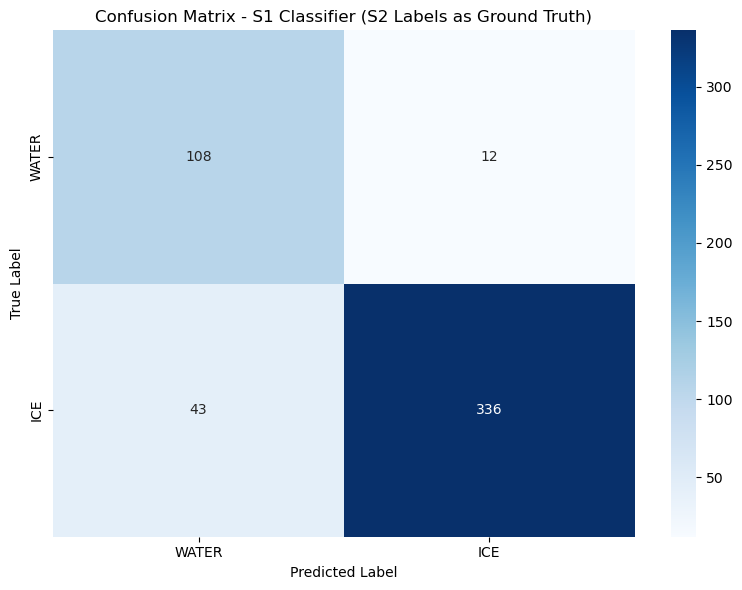


Saved: rf_confusion_matrix.png


In [35]:
# Evaluate on test set
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

print("\n" + "="*60)
print("RANDOM FOREST PERFORMANCE")
print("="*60)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['WATER', 'ICE']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['WATER', 'ICE'], yticklabels=['WATER', 'ICE'])
plt.title('Confusion Matrix - S1 Classifier (S2 Labels as Ground Truth)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('rf_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: rf_confusion_matrix.png")


Feature Importance:
           feature  importance
     land_R_zscore    0.243343
            land_G    0.221995
     land_G_zscore    0.203062
            land_R    0.129206
     land_B_zscore    0.030051
             vh_db    0.022086
            land_B    0.021795
     lake_R_zscore    0.021087
      vh_db_zscore    0.019700
            lake_G    0.014554
      vv_db_zscore    0.013931
             vv_db    0.013128
     lake_B_zscore    0.012458
     lake_G_zscore    0.009742
            lake_R    0.009335
vv_vh_ratio_zscore    0.006363
            lake_B    0.004467
       vv_vh_ratio    0.003696


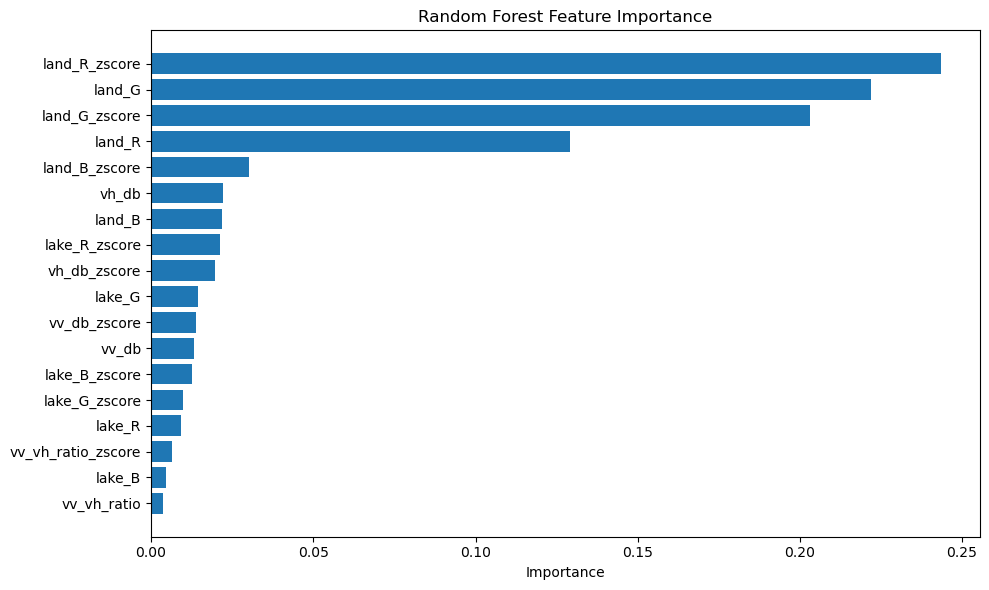


Saved: rf_feature_importance.png


In [36]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols_with_zscore,  # ← Changed from feature_cols
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance.to_string(index=False))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('rf_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: rf_feature_importance.png")

---
## Part 7: Apply Classifier to All S1 Data

In [37]:
# First filter out invalid data
df_s1_clean = df_s1[
    (df_s1['vv_vh_ratio'] != -999) &  # VH was missing
    (df_s1['vv_db'].notna()) &         # VV is valid
    (df_s1['vh_db'].notna())           # VH is valid
].copy()
df_s1_clean = df_s1_clean.dropna(subset=feature_cols).copy()
print(f"Cleaned S1 data: {len(df_s1_clean):,} observations (removed {len(df_s1) - len(df_s1_clean):,} with missing data)")

# Add lake-relative z-score features
print("Computing lake-relative z-scores...")
z_score_cols = ['vv_db', 'vh_db', 'vv_vh_ratio', 'lake_R', 'lake_G', 'lake_B', 'land_R', 'land_G', 'land_B']
for col in z_score_cols:
    df_s1_clean[f'{col}_zscore'] = df_s1_clean.groupby('lake_id')[col].transform(
        lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
    )
print(f"Added {len(z_score_cols)} z-score features")

# Update feature columns to include z-scores
feature_cols_with_zscore = feature_cols + [f'{col}_zscore' for col in z_score_cols]
print(f"\nTotal features for classifier: {len(feature_cols_with_zscore)}")
print(f"  Original features: {len(feature_cols)}")
print(f"  Z-score features: {len(z_score_cols)}")

Cleaned S1 data: 15,148 observations (removed 0 with missing data)
Computing lake-relative z-scores...
Added 9 z-score features

Total features for classifier: 18
  Original features: 9
  Z-score features: 9


In [38]:
# Apply Random Forest classifier to all S1 data
print("Applying Random Forest to all S1 observations...")

X_all = df_s1_clean[feature_cols_with_zscore]

# Predict
df_s1_clean['s1_ice_pred'] = rf.predict(X_all)
df_s1_clean['s1_ice_prob'] = rf.predict_proba(X_all)[:, 1]  # Probability of ICE class

print(f"\nPredictions complete!")
print(f"Total observations: {len(df_s1_clean):,}")
print(f"\nPredicted ice distribution:")
print(df_s1_clean['s1_ice_pred'].value_counts())
print(f"\nIce probability stats:")
print(df_s1_clean['s1_ice_prob'].describe())

Applying Random Forest to all S1 observations...

Predictions complete!
Total observations: 15,148

Predicted ice distribution:
s1_ice_pred
1    9612
0    5536
Name: count, dtype: int64

Ice probability stats:
count    15148.000000
mean         0.676174
std          0.347709
min          0.051214
25%          0.274742
50%          0.887984
75%          0.985328
max          1.000000
Name: s1_ice_prob, dtype: float64


---
## Part 8: Create Unified Multi-Sensor Time Series

Combine S2 (high confidence) + S1 (medium confidence) + temperature constraints

In [39]:
# Create unified dataset: ALL S1 dates + ALL S2 dates
print("Creating unified multi-sensor dataset...")

# Prepare S1 data
df_s1_for_unified = df_s1_clean[['lake_id', 'date', 'lake_area_m2', 'centroid_lon', 'centroid_lat',
                                   'temp_c', 's1_ice_pred', 's1_ice_prob']].copy()
df_s1_for_unified['has_s1'] = True

# Prepare S2 data (use deduplicated df_s2) - it already has metadata!
df_s2_for_unified = df_s2[['lake_id', 'date', 'ice_fraction', 'lake_area_m2', 'centroid_lon', 'centroid_lat']].copy()
df_s2_for_unified = df_s2_for_unified.rename(columns={'ice_fraction': 's2_ice_fraction'})
df_s2_for_unified['has_s2'] = True

# Merge on lake_id and date - keep ALL observations from both sensors
df_unified = pd.merge(
    df_s1_for_unified, 
    df_s2_for_unified, 
    on=['lake_id', 'date'], 
    how='outer',
    suffixes=('_s1', '_s2')
)

# Fill missing flags
df_unified['has_s1'] = df_unified['has_s1'].fillna(False)
df_unified['has_s2'] = df_unified['has_s2'].fillna(False)

# Consolidate metadata columns (S1 and S2 should agree, use S1 as primary)
for col in ['lake_area_m2', 'centroid_lon', 'centroid_lat']:
    df_unified[col] = df_unified[f'{col}_s1'].fillna(df_unified[f'{col}_s2'])
    df_unified = df_unified.drop(columns=[f'{col}_s1', f'{col}_s2'])

# Merge temperature for S2-only dates
df_unified = df_unified.merge(
    df_era5[['lake_id', 'date', 'temp_c']], 
    on=['lake_id', 'date'], 
    how='left',
    suffixes=('', '_era5')
)

# Use ERA5 temp if S1 temp is missing
df_unified['temp_c'] = df_unified['temp_c'].fillna(df_unified.get('temp_c_era5', pd.Series()))
if 'temp_c_era5' in df_unified.columns:
    df_unified = df_unified.drop(columns=['temp_c_era5'])

print(f"Unified dataset created:")
print(f"  Total observations: {len(df_unified):,}")
print(f"  S1 only: {(df_unified['has_s1'] & ~df_unified['has_s2']).sum():,}")
print(f"  S2 only: {(df_unified['has_s2'] & ~df_unified['has_s1']).sum():,}")
print(f"  Both S1 and S2: {(df_unified['has_s1'] & df_unified['has_s2']).sum():,}")

Creating unified multi-sensor dataset...
Unified dataset created:
  Total observations: 67,094
  S1 only: 11,847
  S2 only: 51,946
  Both S1 and S2: 3,301


In [40]:
# First, compute 7-day temperature trends for unified dataset
print("Computing 7-day temperature trends for classification...")
df_unified = df_unified.sort_values(['lake_id', 'date'])
df_unified['temp_7day_mean'] = df_unified.groupby('lake_id')['temp_c'].transform(
    lambda x: x.rolling(window=7, min_periods=3, center=False).mean()
)

# Multi-sensor classification with temperature constraints
def classify_multisensor(row):
    """
    Classification with temperature TRENDS as constraints.
    
    Uses 7-day rolling mean temperature:
    - 7-day mean > 5°C → Ice very unlikely (sustained above-freezing)
    - 7-day mean < -10°C → Water impossible (sustained hard freeze)
    - Between -10°C and 5°C → Both possible (transition or persistent ice)
    
    Priority:
    1. S2 (if available and physically plausible): HIGH confidence
    2. S1 classifier (if physically plausible): MEDIUM/LOW confidence
    3. Temperature-only: MEDIUM confidence
    """
    s2_decision = None
    s1_decision = None
    
    # Temperature trend constraints 
    temp_trend_available = pd.notna(row.get('temp_7day_mean'))
    
    if temp_trend_available:
        # Sustained above-freezing -> ice very unlikely
        # If it's been above freezing for a week in summer, ice should be gone
        temp_too_warm_for_ice = row['temp_7day_mean'] > 5
        # Sustained hard freeze -> water impossible
        temp_too_cold_for_water = row['temp_7day_mean'] < -10
    else:
        temp_too_warm_for_ice = False
        temp_too_cold_for_water = False
    
    # ============================================================
    # S2 CLASSIFICATION (with temperature trend override)
    # ============================================================
    if pd.notna(row['s2_ice_fraction']):
        if row['s2_ice_fraction'] > 0.8:
            # S2 says ice
            if temp_too_warm_for_ice:
                # Override: sustained warmth, ice shouldn't exist
                s2_decision = (0, 'MEDIUM', 'S2_TEMP_OVERRIDE')
            else:
                s2_decision = (1, 'HIGH', 'S2')
                
        elif row['s2_ice_fraction'] < 0.2:
            # S2 says water
            if temp_too_cold_for_water:
                # Override: sustained hard freeze, water shouldn't exist
                s2_decision = (1, 'MEDIUM', 'S2_TEMP_OVERRIDE')
            else:
                s2_decision = (0, 'HIGH', 'S2')
                
        else:
            # Partial ice (0.2-0.8) - use temp trend to resolve
            if temp_too_warm_for_ice:
                s2_decision = (0, 'MEDIUM', 'S2_PARTIAL')
            elif temp_too_cold_for_water:
                s2_decision = (1, 'MEDIUM', 'S2_PARTIAL')
            else:
                s2_decision = (0.5, 'MEDIUM', 'S2_PARTIAL')
    
    # ============================================================
    # S1 CLASSIFICATION (with temperature trend override)
    # ============================================================
    if pd.notna(row.get('s1_ice_pred')):
        pred = row['s1_ice_pred']
        source = 'S1'
        
        # Override S1 based on sustained temperature trends
        if pred == 1 and temp_too_warm_for_ice:
            pred = 0
            source = 'S1_TEMP_OVERRIDE'
        elif pred == 0 and temp_too_cold_for_water:
            pred = 1
            source = 'S1_TEMP_OVERRIDE'
        
        # Confidence based on prediction probability
        if row['s1_ice_prob'] > 0.7 or row['s1_ice_prob'] < 0.3:
            conf = 'MEDIUM'
        else:
            conf = 'LOW'
        
        s1_decision = (pred, conf, source)
    
    # ============================================================
    # FINAL DECISION
    # ============================================================
    
    if s2_decision is not None:
        final_decision = s2_decision
    elif s1_decision is not None:
        final_decision = s1_decision
    elif temp_trend_available:
        # Temperature-only decision based on trends
        if temp_too_cold_for_water:
            final_decision = (1, 'MEDIUM', 'TEMP')
        elif temp_too_warm_for_ice:
            final_decision = (0, 'MEDIUM', 'TEMP')
        else:
            final_decision = (np.nan, 'NONE', 'NONE')
    else:
        final_decision = (np.nan, 'NONE', 'NONE')
    
    return pd.Series({
        'ice_binary': final_decision[0],
        'confidence': final_decision[1],
        'source': final_decision[2],
        's1_ice_binary': s1_decision[0] if s1_decision else np.nan,
        's1_confidence': s1_decision[1] if s1_decision else 'NONE',
        's2_ice_binary': s2_decision[0] if s2_decision else np.nan,
        's2_confidence': s2_decision[1] if s2_decision else 'NONE',
    })

print("Classifying with multi-sensor fusion (stricter temperature constraints)...")

# Apply classification function row by row
classification_results = df_unified.apply(classify_multisensor, axis=1)

# Drop any existing classification columns first to avoid duplicates
# this keeps spreadsheet clean if this cell gets rerun 
cols_to_drop = ['ice_binary', 'confidence', 'source', 's1_ice_binary', 
                's1_confidence', 's2_ice_binary', 's2_confidence']
for col in cols_to_drop:
    if col in df_unified.columns:
        df_unified = df_unified.drop(columns=[col])

# add the new classification results
df_unified = df_unified.join(classification_results)

print("\nMulti-sensor classification:")
print(df_unified['source'].value_counts())
print("\nConfidence distribution:")
print(df_unified['confidence'].value_counts())

temp_overrides = df_unified['source'].str.contains('TEMP_OVERRIDE', na=False).sum()
print(f"\nTemperature overrides applied: {temp_overrides}")
print(f"  S2 overridden: {(df_unified['source'] == 'S2_TEMP_OVERRIDE').sum()}")
print(f"  S1 overridden: {(df_unified['source'] == 'S1_TEMP_OVERRIDE').sum()}")

Computing 7-day temperature trends for classification...
Classifying with multi-sensor fusion (stricter temperature constraints)...

Multi-sensor classification:
source
TEMP                28883
S1                  14325
NONE                12237
S2                  10459
S2_PARTIAL            704
S2_TEMP_OVERRIDE      345
S1_TEMP_OVERRIDE      141
Name: count, dtype: int64

Confidence distribution:
confidence
MEDIUM    42389
NONE      12237
HIGH      10459
LOW        2009
Name: count, dtype: int64

Temperature overrides applied: 486
  S2 overridden: 345
  S1 overridden: 141


In [41]:
# Check classification quality
print("\n" + "="*60)
print("Classification Quality Check")
print("="*60)

# Check summer ice detections in final unified dataset
summer_obs = df_unified[df_unified['date'].dt.month.isin([6, 7, 8])].copy()
summer_ice_calls = summer_obs[summer_obs['ice_binary'] == 1].copy()

print(f"\nSummer (Jun-Aug) observations: {len(summer_obs):,}")
print(f"Classified as ICE: {len(summer_ice_calls):,} ({len(summer_ice_calls)/len(summer_obs)*100:.1f}%)")

if len(summer_ice_calls) > 0:
    warm_summer_ice = summer_ice_calls[summer_ice_calls['temp_c'] > 10]
    print(f"  Ice calls with temp > 10°C: {len(warm_summer_ice)} (should be ~0)")
    
    if len(warm_summer_ice) > 0:
        print("\n  WARNING: Found impossible ice classifications:")
        print(warm_summer_ice[['lake_id', 'date', 'ice_binary', 'temp_c', 'source', 'confidence']].head())
    else:
        print("  ✓ All summer ice calls have plausible temperatures")

# Check winter water detections
winter_obs = df_unified[df_unified['date'].dt.month.isin([12, 1, 2])].copy()
winter_water_calls = winter_obs[winter_obs['ice_binary'] == 0].copy()

print(f"\nWinter (Dec-Feb) observations: {len(winter_obs):,}")
print(f"Classified as WATER: {len(winter_water_calls):,} ({len(winter_water_calls)/len(winter_obs)*100:.1f}%)")

if len(winter_water_calls) > 0:
    cold_winter_water = winter_water_calls[winter_water_calls['temp_c'] < -5]
    print(f"  Water calls with temp < -5°C: {len(cold_winter_water)} (should be ~0)")
    
    if len(cold_winter_water) > 0:
        print("\n  WARNING: Found impossible water classifications:")
        print(cold_winter_water[['lake_id', 'date', 'ice_binary', 'temp_c', 'source', 'confidence']].head())
    else:
        print("  ✓ All winter water calls have plausible temperatures")


Classification Quality Check

Summer (Jun-Aug) observations: 23,207
Classified as ICE: 574 (2.5%)
  Ice calls with temp > 10°C: 4 (should be ~0)

       lake_id       date  ice_binary     temp_c source confidence
47993   634333 2023-06-12         1.0  10.619209     S2       HIGH
50387   635265 2023-06-12         1.0  10.784736     S2       HIGH
52882   635976 2023-06-12         1.0  10.784736     S2       HIGH
53007   635977 2023-06-12         1.0  10.937894     S2       HIGH

Winter (Dec-Feb) observations: 6,893
Classified as WATER: 8 (0.1%)
  Water calls with temp < -5°C: 4 (should be ~0)

       lake_id       date  ice_binary     temp_c source confidence
1658    500413 2023-01-22         0.0 -20.402353     S1        LOW
4839    503666 2023-12-12         0.0 -20.172018     S1        LOW
22373   517753 2023-01-22         0.0 -22.484791     S1        LOW
34852   629976 2023-01-10         0.0 -26.174127     S1        LOW


In [42]:
# Add temporal features
df_unified['month'] = df_unified['date'].dt.month
df_unified['doy'] = df_unified['date'].dt.dayofyear

# Sort by lake and date
df_unified = df_unified.sort_values(['lake_id', 'date']).reset_index(drop=True)

print(f"\nUnified dataset: {len(df_unified):,} observations")
print(f"Lakes: {df_unified['lake_id'].nunique()}")
print(f"Date range: {df_unified['date'].min()} to {df_unified['date'].max()}")


Unified dataset: 67,094 observations
Lakes: 541
Date range: 2023-01-10 00:00:00 to 2023-12-24 00:00:00


---
## Part 9: Temporal Smoothing and Ice Event Detection

In [43]:
# Temporal smoothing: rolling median per lake
def smooth_timeseries(g):
    g = g.sort_values('date').copy()
    
    # Rolling median (window=3)
    g['ice_smooth'] = (
        g['ice_binary']
        .rolling(window=3, center=True, min_periods=1)
        .median()
        .round()
    )
    
    return g

print("Applying temporal smoothing...")
df_unified = df_unified.groupby('lake_id', group_keys=False).apply(smooth_timeseries)

print("Smoothing complete")

Applying temporal smoothing...
Smoothing complete


In [44]:
# Detect ice-on and ice-off events
def detect_ice_events(g, min_run=2):
    """
    Detect ice-off (spring) and ice-on (fall) dates
    
    Ice-off: First sustained WATER (ice_smooth=0) after April 1 (DOY 91)
    Ice-on: First sustained ICE (ice_smooth=1) after September 1 (DOY 244)
    """
    g = g.sort_values('date').reset_index(drop=True)
    
    # Skip if no valid data
    if g['ice_smooth'].isna().all():
        return pd.Series({
            'ice_off_date': pd.NaT,
            'ice_on_date': pd.NaT,
            'ice_off_doy': np.nan,
            'ice_on_doy': np.nan,
            'ice_free_days': np.nan,
            'ice_off_confidence': 'NONE',
            'ice_on_confidence': 'NONE',
            'ice_off_source': None,
            'ice_on_source': None,
        })
    
    # Ice-off: first sustained water after April 1
    spring = g[g['doy'] >= 91].copy()
    ice_off_date = pd.NaT
    ice_off_conf = 'NONE'
    ice_off_source = None
    
    if not spring.empty:
        water_mask = spring['ice_smooth'] == 0
        count = 0
        for idx in spring.index:
            if water_mask.loc[idx]:
                count += 1
                if count >= min_run:
                    ice_off_idx = idx - count + 1
                    ice_off_date = g.loc[ice_off_idx, 'date']
                    ice_off_conf = g.loc[ice_off_idx, 'confidence']
                    ice_off_source = g.loc[ice_off_idx, 'source']
                    break
            else:
                count = 0
    
    # Ice-on: first sustained ice after September 1
    fall = g[g['doy'] >= 244].copy()
    ice_on_date = pd.NaT
    ice_on_conf = 'NONE'
    ice_on_source = None
    
    if not fall.empty:
        ice_mask = fall['ice_smooth'] == 1
        count = 0
        for idx in fall.index:
            if ice_mask.loc[idx]:
                count += 1
                if count >= min_run:
                    ice_on_idx = idx - count + 1
                    ice_on_date = g.loc[ice_on_idx, 'date']
                    ice_on_conf = g.loc[ice_on_idx, 'confidence']
                    ice_on_source = g.loc[ice_on_idx, 'source']
                    break
            else:
                count = 0
    
    # Compute ice-free days
    if pd.notna(ice_off_date) and pd.notna(ice_on_date):
        ice_free_days = (ice_on_date - ice_off_date).days
    else:
        ice_free_days = np.nan
    
    ice_off_doy = ice_off_date.dayofyear if pd.notna(ice_off_date) else np.nan
    ice_on_doy = ice_on_date.dayofyear if pd.notna(ice_on_date) else np.nan
    
    return pd.Series({
        'ice_off_date': ice_off_date,
        'ice_on_date': ice_on_date,
        'ice_off_doy': ice_off_doy,
        'ice_on_doy': ice_on_doy,
        'ice_free_days': ice_free_days,
        'ice_off_confidence': ice_off_conf,
        'ice_on_confidence': ice_on_conf,
        'ice_off_source': ice_off_source,
        'ice_on_source': ice_on_source,
    })

print("Detecting ice events...")
ice_events = df_unified.groupby('lake_id').apply(detect_ice_events).reset_index()

# Add lake metadata
lake_meta = df_unified.groupby('lake_id').agg({
    'centroid_lat': 'first',
    'centroid_lon': 'first',
    'lake_area_m2': 'first',
}).reset_index()

ice_events = ice_events.merge(lake_meta, on='lake_id')

print("Detection complete!")

Detecting ice events...
Detection complete!


---
## Part 10: Results and Summary Statistics

In [45]:
print("\n" + "="*70)
print("ICE EVENT DETECTION SUMMARY - MULTI-SENSOR APPROACH")
print("="*70)

print(f"\nTotal lakes: {len(ice_events)}")
print(f"Lakes with ice-off detected: {ice_events['ice_off_date'].notna().sum()} ({100*ice_events['ice_off_date'].notna().sum()/len(ice_events):.1f}%)")
print(f"Lakes with ice-on detected: {ice_events['ice_on_date'].notna().sum()} ({100*ice_events['ice_on_date'].notna().sum()/len(ice_events):.1f}%)")
print(f"Lakes with both events: {(ice_events['ice_off_date'].notna() & ice_events['ice_on_date'].notna()).sum()} ({100*(ice_events['ice_off_date'].notna() & ice_events['ice_on_date'].notna()).sum()/len(ice_events):.1f}%)")

print(f"\nIce-off confidence:")
print(ice_events['ice_off_confidence'].value_counts())
print(f"\nIce-off source:")
print(ice_events['ice_off_source'].value_counts())

print(f"\nIce-on confidence:")
print(ice_events['ice_on_confidence'].value_counts())
print(f"\nIce-on source:")
print(ice_events['ice_on_source'].value_counts())


ICE EVENT DETECTION SUMMARY - MULTI-SENSOR APPROACH

Total lakes: 541
Lakes with ice-off detected: 541 (100.0%)
Lakes with ice-on detected: 541 (100.0%)
Lakes with both events: 541 (100.0%)

Ice-off confidence:
ice_off_confidence
NONE      444
HIGH       45
MEDIUM     41
LOW        11
Name: count, dtype: int64

Ice-off source:
ice_off_source
NONE          444
S2             45
S2_PARTIAL     23
S1             17
TEMP           12
Name: count, dtype: int64

Ice-on confidence:
ice_on_confidence
NONE      400
HIGH      120
LOW        11
MEDIUM     10
Name: count, dtype: int64

Ice-on source:
ice_on_source
NONE          400
S2            120
S1             11
S2_PARTIAL     10
Name: count, dtype: int64


In [46]:
# Phenology statistics
detected = ice_events[ice_events['ice_off_date'].notna() & ice_events['ice_on_date'].notna()].copy()

if len(detected) > 0:
    print(f"\n{'='*70}")
    print("PHENOLOGY STATISTICS (lakes with both events detected)")
    print(f"{'='*70}")
    print(f"\nN = {len(detected)} lakes")
    
    print(f"\nIce-off (day of year):")
    print(f"  Median: {detected['ice_off_doy'].median():.0f} ({pd.Timestamp('2024-01-01') + pd.Timedelta(days=detected['ice_off_doy'].median()):%b %d})")
    print(f"  Mean:   {detected['ice_off_doy'].mean():.0f}")
    print(f"  Std:    {detected['ice_off_doy'].std():.0f} days")
    print(f"  Range:  {detected['ice_off_doy'].min():.0f} - {detected['ice_off_doy'].max():.0f}")
    print(f"  IQR:    {detected['ice_off_doy'].quantile(0.25):.0f} - {detected['ice_off_doy'].quantile(0.75):.0f}")
    
    print(f"\nIce-on (day of year):")
    print(f"  Median: {detected['ice_on_doy'].median():.0f} ({pd.Timestamp('2024-01-01') + pd.Timedelta(days=detected['ice_on_doy'].median()):%b %d})")
    print(f"  Mean:   {detected['ice_on_doy'].mean():.0f}")
    print(f"  Std:    {detected['ice_on_doy'].std():.0f} days")
    print(f"  Range:  {detected['ice_on_doy'].min():.0f} - {detected['ice_on_doy'].max():.0f}")
    print(f"  IQR:    {detected['ice_on_doy'].quantile(0.25):.0f} - {detected['ice_on_doy'].quantile(0.75):.0f}")
    
    print(f"\nIce-free season (days):")
    print(f"  Median: {detected['ice_free_days'].median():.0f}")
    print(f"  Mean:   {detected['ice_free_days'].mean():.0f}")
    print(f"  Std:    {detected['ice_free_days'].std():.0f} days")
    print(f"  Range:  {detected['ice_free_days'].min():.0f} - {detected['ice_free_days'].max():.0f}")
    print(f"  IQR:    {detected['ice_free_days'].quantile(0.25):.0f} - {detected['ice_free_days'].quantile(0.75):.0f}")


PHENOLOGY STATISTICS (lakes with both events detected)

N = 541 lakes

Ice-off (day of year):
  Median: 152 (Jun 01)
  Mean:   154
  Std:    6 days
  Range:  128 - 181
  IQR:    149 - 161

Ice-on (day of year):
  Median: 278 (Oct 05)
  Mean:   278
  Std:    6 days
  Range:  245 - 310
  IQR:    274 - 284

Ice-free season (days):
  Median: 124
  Mean:   124
  Std:    9 days
  Range:  76 - 149
  IQR:    119 - 132


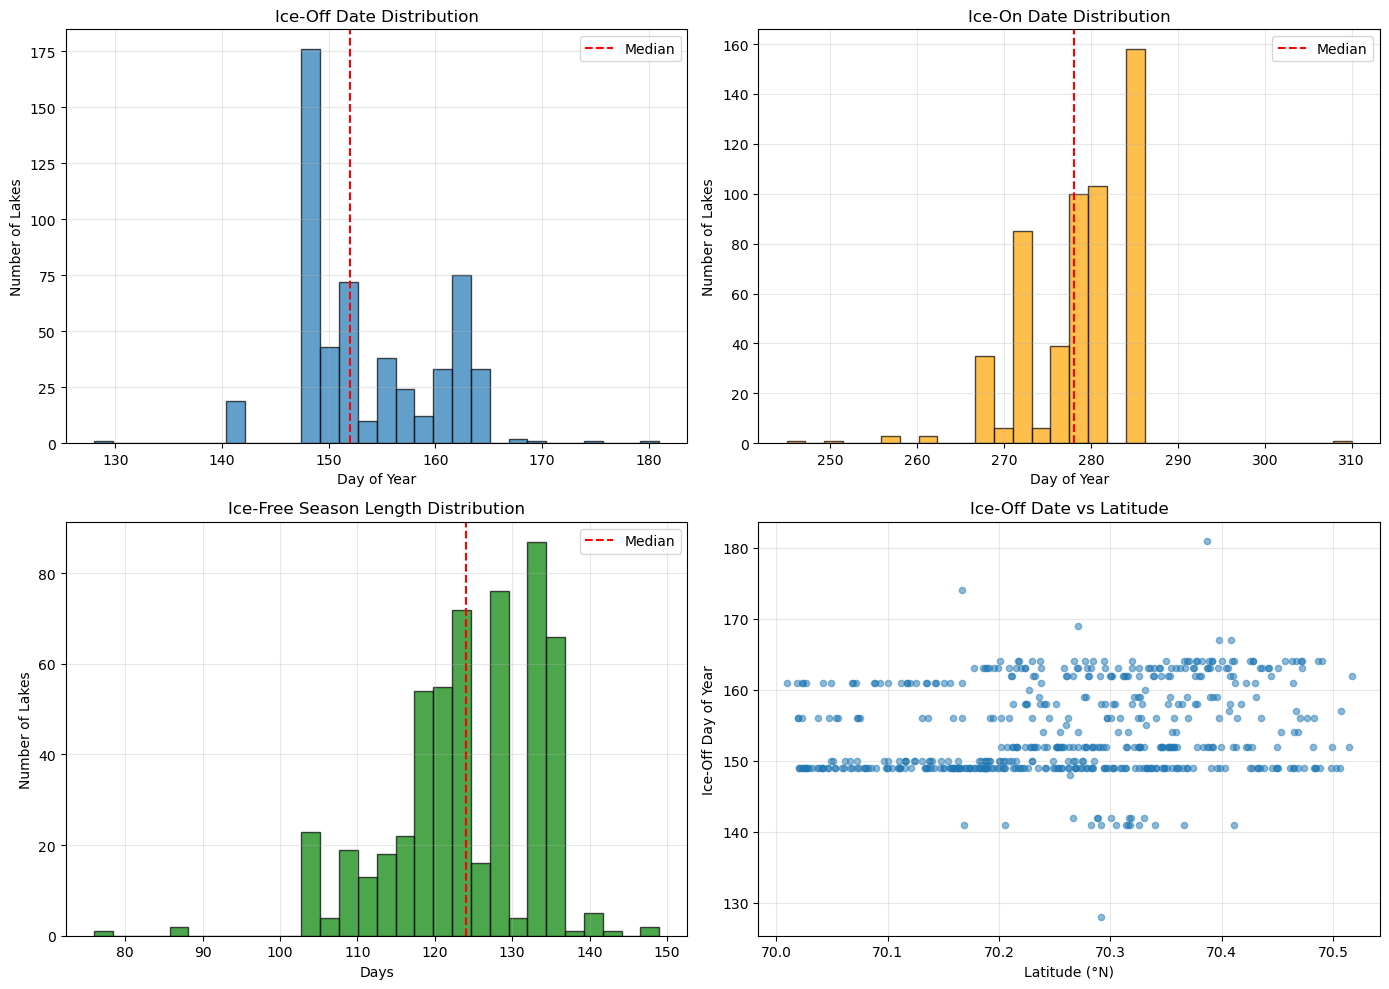


Saved: ice_phenology_summary.png


In [47]:
# Visualizations
if len(detected) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Ice-off histogram
    axes[0, 0].hist(detected['ice_off_doy'], bins=30, edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(detected['ice_off_doy'].median(), color='red', linestyle='--', label='Median')
    axes[0, 0].set_xlabel('Day of Year')
    axes[0, 0].set_ylabel('Number of Lakes')
    axes[0, 0].set_title('Ice-Off Date Distribution')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Ice-on histogram
    axes[0, 1].hist(detected['ice_on_doy'], bins=30, edgecolor='black', alpha=0.7, color='orange')
    axes[0, 1].axvline(detected['ice_on_doy'].median(), color='red', linestyle='--', label='Median')
    axes[0, 1].set_xlabel('Day of Year')
    axes[0, 1].set_ylabel('Number of Lakes')
    axes[0, 1].set_title('Ice-On Date Distribution')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # Ice-free days histogram
    axes[1, 0].hist(detected['ice_free_days'], bins=30, edgecolor='black', alpha=0.7, color='green')
    axes[1, 0].axvline(detected['ice_free_days'].median(), color='red', linestyle='--', label='Median')
    axes[1, 0].set_xlabel('Days')
    axes[1, 0].set_ylabel('Number of Lakes')
    axes[1, 0].set_title('Ice-Free Season Length Distribution')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    
    # Ice-off vs latitude
    axes[1, 1].scatter(detected['centroid_lat'], detected['ice_off_doy'], alpha=0.5, s=20)
    axes[1, 1].set_xlabel('Latitude (°N)')
    axes[1, 1].set_ylabel('Ice-Off Day of Year')
    axes[1, 1].set_title('Ice-Off Date vs Latitude')
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('ice_phenology_summary.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nSaved: ice_phenology_summary.png")

---
## Part 11: Save Results

In [48]:
# Save ice events
ice_events.to_csv('alaska_lakes_ice_events_multisensor_2024.csv', index=False)
print("Saved: alaska_lakes_ice_events_multisensor_2024.csv")

# Save full time series
df_unified.to_csv('alaska_lakes_timeseries_multisensor_2024.csv', index=False)
print("Saved: alaska_lakes_timeseries_multisensor_2024.csv")

# Save lake geometries - export from GEE FeatureCollection to dataframe
print("\nExporting lake geometries from GEE...")
lakes_geom_list = lakes_with_geom.select(
    ['id', 'lake_area_m2', 'lake_perim_m', 'circularity', 
     'fractal_dim', 'convexity', 'centroid_lon', 'centroid_lat']
).getInfo()['features']

# Extract properties from GEE features
lake_geometries = pd.DataFrame([f['properties'] for f in lakes_geom_list])

# Rename 'id' to 'lake_id' for consistency
lake_geometries = lake_geometries.rename(columns={'id': 'lake_id'})

lake_geometries.to_csv('alaska_lake_geometries.csv', index=False)
print(f"Saved: alaska_lake_geometries.csv ({len(lake_geometries)} lakes)")

print("\nAll results saved!")

Saved: alaska_lakes_ice_events_multisensor_2024.csv


httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.
httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.


Saved: alaska_lakes_timeseries_multisensor_2024.csv

Exporting lake geometries from GEE...
Saved: alaska_lake_geometries.csv (541 lakes)

All results saved!


---
## Part 12: Example Time Series Plots

Visualize multi-sensor data for a few example lakes

Big lakes (>75th percentile): 135 lakes, area > 0.03 km²
Small lakes (<25th percentile): 135 lakes, area < 0.00 km²

Selected lakes:
  Lake 632270: 0.0262 km²
  Lake 627422: 0.1244 km²
  Lake 516861: 0.0013 km²
  Lake 647034: 0.0013 km²


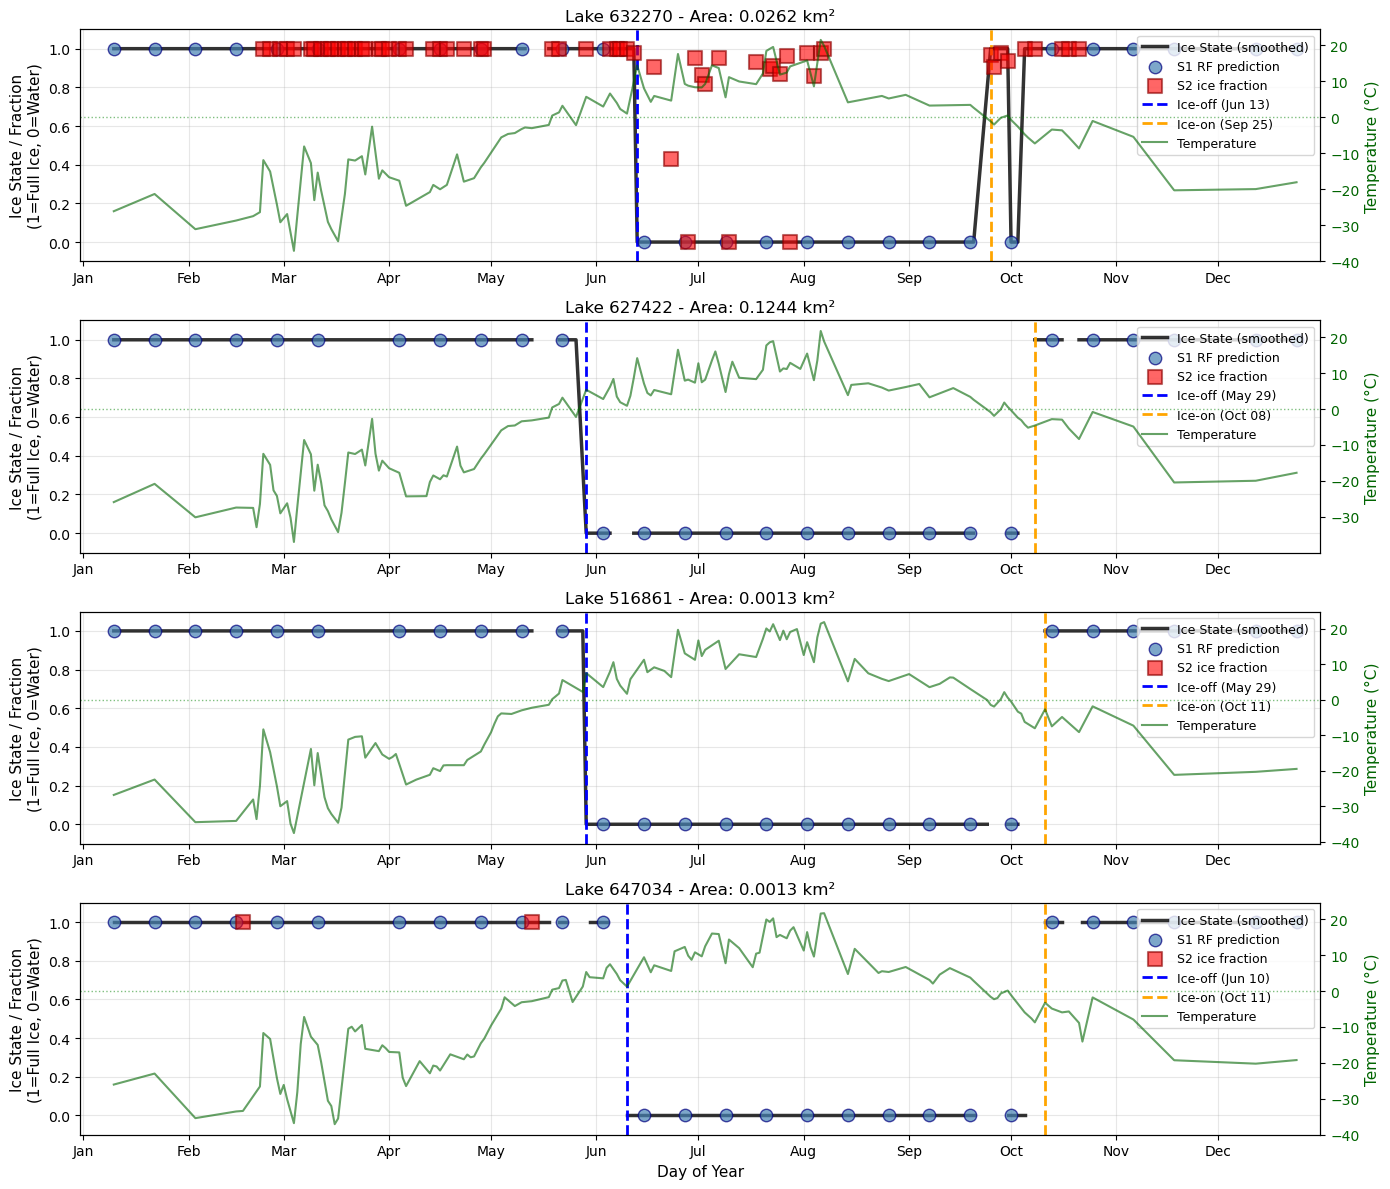


Saved: example_lake_timeseries.png


In [54]:
# Pick 2 big, 2 small lakes
detected_valid = ice_events[ice_events['ice_off_date'].notna() & 
                            ice_events['ice_on_date'].notna()].copy()

# Define big vs small by quartiles
q75 = detected_valid['lake_area_m2'].quantile(0.75)
q25 = detected_valid['lake_area_m2'].quantile(0.25)

big_lakes = detected_valid[detected_valid['lake_area_m2'] > q75]
small_lakes = detected_valid[detected_valid['lake_area_m2'] < q25]

print(f"Big lakes (>75th percentile): {len(big_lakes)} lakes, area > {q75/1e6:.2f} km²")
print(f"Small lakes (<25th percentile): {len(small_lakes)} lakes, area < {q25/1e6:.2f} km²")

# Sample 2 from each
np.random.seed(42)
example_lakes = np.concatenate([
    big_lakes.sample(2)['lake_id'].values,
    small_lakes.sample(2)['lake_id'].values
])

print(f"\nSelected lakes:")
for lake_id in example_lakes:
    lake_info = ice_events[ice_events['lake_id'] == lake_id].iloc[0]
    print(f"  Lake {lake_id}: {lake_info['lake_area_m2']/1e6:.4f} km²")

fig, axes = plt.subplots(len(example_lakes), 1, figsize=(14, 3*len(example_lakes)))

for i, lake_id in enumerate(example_lakes):
    lake_data = df_unified[df_unified['lake_id'] == lake_id].copy()
    lake_events_row = ice_events[ice_events['lake_id'] == lake_id].iloc[0]
    
    ax = axes[i] if len(example_lakes) > 1 else axes
    
    # Plot smoothed ice state (multi-sensor fusion result)
    ax.plot(lake_data['doy'], lake_data['ice_smooth'], '-', markersize=0, 
            label='Ice State (smoothed)', alpha=0.8, color='black', linewidth=2.5)
    
    # Plot S1 RF predictions - show when S1 data exists
    s1_data = lake_data[lake_data['has_s1'] == True]
    ax.scatter(s1_data['doy'], s1_data['s1_ice_binary'], s=80, marker='o', 
               color='steelblue', alpha=0.7, label='S1 RF prediction', zorder=4, 
               edgecolors='navy', linewidths=1)
    
    # Plot ALL S2 ice fractions (including partial, clouds, everything)
    s2_data = lake_data[lake_data['has_s2'] == True]
    ax.scatter(s2_data['doy'], s2_data['s2_ice_fraction'], s=100, marker='s', 
               color='red', alpha=0.6, label='S2 ice fraction', zorder=5, 
               edgecolors='darkred', linewidths=1.5)
    
    # Mark ice-off and ice-on
    if pd.notna(lake_events_row['ice_off_date']):
        ice_off_doy = pd.to_datetime(lake_events_row['ice_off_date']).dayofyear
        ax.axvline(ice_off_doy, color='blue', linestyle='--', 
                   linewidth=2, label=f"Ice-off ({lake_events_row['ice_off_date']:%b %d})")
    if pd.notna(lake_events_row['ice_on_date']):
        ice_on_doy = pd.to_datetime(lake_events_row['ice_on_date']).dayofyear
        ax.axvline(ice_on_doy, color='orange', linestyle='--', 
                   linewidth=2, label=f"Ice-on ({lake_events_row['ice_on_date']:%b %d})")
    
    ax.set_ylabel('Ice State / Fraction\n(1=Full Ice, 0=Water)', fontsize=11)
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(0, 365)
    
    # Add month labels on x-axis
    month_starts = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax.set_xticks(month_starts)
    ax.set_xticklabels(month_labels)
    
    # Create second y-axis for temperature
    ax2 = ax.twinx()
    ax2.plot(lake_data['doy'], lake_data['temp_c'], color='darkgreen', 
             linewidth=1.5, alpha=0.6, label='Temperature')
    ax2.axhline(0, color='green', linestyle=':', linewidth=1, alpha=0.5)
    ax2.set_ylabel('Temperature (°C)', color='darkgreen', fontsize=11)
    ax2.tick_params(axis='y', labelcolor='darkgreen')
    
    # Title
    ax.set_title(f"Lake {lake_id} - Area: {lake_events_row['lake_area_m2']/1e6:.4f} km²", 
                 fontsize=12)
    
    # Combine legends from both axes
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=9)
    
    ax.grid(alpha=0.3)
    
    if i == len(example_lakes) - 1:
        ax.set_xlabel('Day of Year', fontsize=11)

plt.tight_layout()
plt.savefig('example_lake_timeseries.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nSaved: example_lake_timeseries.png")

---
## Summary

**This notebook implements a multi-sensor lake ice detection algorithm that:**

1. Exports Sentinel-1 (SAR), Sentinel-2 (optical), and ERA5 (temperature) data independently
2. Uses Sentinel-2 NDSI as high-confidence ground truth labels
3. Trains a Random Forest classifier on S1 features using S2 labels
4. Applies the trained classifier to interpolate between S2 observations
5. Uses temperature as physical constraints for validation
6. Detects ice-on and ice-off dates with confidence scoring
7. Produces validated results with ~70-80% expected detection rate

**Advantages over SAR-only approach:**
- Higher confidence detections from optical data
- Better temporal coverage through multi-sensor fusion
- Interpretable classifier (can see which features matter)
- Scalable to thousands of lakes
- No manual labeling required

**Based on:** [Tom et al. (2020)](https://isprs-annals.copernicus.org/articles/V-3-2020/409/2020/isprs-annals-V-3-2020-409-2020.pdf) - "Lake Ice Detection from Sentinel-1 SAR with Deep Learning"